In [1]:
## Scaffold for Michelangelo customers 
## authors: will.zou@uber.com dmantar@uber.com 
## Causal Models for real-time incentives 
## import libraries and modules 

import sys, os, pandas as pd, numpy as np, pickle as pkl, tensorflow as tf 
sys.path.append('../dataprep/') 
from QueryFunctions import * 


In [2]:
### pull data either using queryrunner or using csv 
use_query = 0 ### turn this switch on (to 1.0/True vs 0.0/False) to run query using QueryRunner 
use_python3 = True 

if use_query: 
    from queryrunner_client import Client 
    qr = Client(user_email='will.zou@uber.com') 
    ##label_dates_weekly = "'2019-07-14', '2019-07-21', '2019-07-28', '2019-08-04'" 
    ##city_ids = '1,5,6,8,10,12,20,23,198' 
    #feature_dates="'2019-06-30'" 
    #proposal_start_date = '2019-07-08' 
    
    predFrame2 = qr.execute('presto', rt_data_presto_first()) 
    predFrame2 = pd.DataFrame(predFrame2.load_data()) 
else: 
    predFrame2 = pd.read_csv('../data/rt_query_result.csv') 


/Users/will.zou/code/deeplearning_hscls/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
### Cross check on treatment and control cohort sizes 
cohort_column_name = 'treatment' 
treatment_indicator_value = True 
control_indicator_value = False 
print('size of dataset:') 
print(len(predFrame2)) 
print('size of control cohort:') 
print(sum(predFrame2[cohort_column_name] == control_indicator_value)) 
print('size of treatment cohort:') 
print(sum(predFrame2[cohort_column_name] == treatment_indicator_value)) 


size of dataset:
728056
size of control cohort:
588443
size of treatment cohort:
139613


In [4]:
### we should process the data such that route level cost and gains are per-session 
### so it's possible to rank the routes separately and it should be able to compare with results for 
### using rider information only 

### three data tables: 
### 1. with rider + route features and per route metrics 
### 2. with rider features and per rider metrics 
### 3. with route features and per route metrics 

### for table 1, we can have two algorithms 
### a. train a model on Table 2, score the riders as a feature for route-level model, then use route level model to evaluate 
### b. train a combined model on table 1 


In [6]:
D[D['rider_id']=='b57c08f5-edfd-441c-ad2d-08ecda3391fb']['gross_bookings_usd']
D[D['rider_id']=='b57c08f5-edfd-441c-ad2d-08ecda3391fb']['num_sessions']

108382    23
236813    23
82665     23
144020    23
208995    23
197188    23
91703     23
193997    23
75936     23
135911    23
228923    23
154105    23
84510     23
199805    23
122896    23
106052    23
193822    23
205383    23
232041    23
209365    23
114163    23
97804     23
79339     23
Name: num_sessions, dtype: int64

In [7]:
print('number of sessions in sum: ' + str(sum(num_sessions)))
print('number of samples in dataset: ' + str(len(D)))
print('total gross bookings: ' + str(sum(values)))
print('total variable contribution: ' + str(sum(negcost)))
#sum(D[label_list[0]].values)
len(D.groupby('rider_id').sum())

number of sessions in sum: 7785582.0
number of samples in dataset: 728056
total gross bookings: 9132459.525520058
total variable contribution: 663475.4613294256


152417

In [8]:
print('treatment vc: ' + str(sum(negcost[w > 0.5]))) 
print('control vc: ' + str(sum(negcost[w < 0.5]))) 

treatment vc: -132198.5303646423
control vc: 795673.9916940761


In [9]:
### preprocess the data 
### -- sample treatment to match control cohort 
### -- eliminate nulls, standard normalization 

D = predFrame2 
D = D.sample(frac=1.0) 


feature_list = [ 
    'rating_2driver_min_avg_84d'
    , 'days_active_84d'
    , 'days_since_trip_first_lifetime'
    , 'days_since_last_soft_churn_lifetime'
    , 'churns_hard_lifetime'
    , 'fare_max_p50_84d'
    , 'fare_total_win7d_sd_84d'
    , 'trip_complete_win7d_sd_84d'
    , 'trip_pool_prc_84d'
    , 'session_request_prc_84d'
    , 'days_since_trip_last_lifetime'
    , 'fare_promo_total_avg_84d'
    , 'fare_total_avg_84d'
    , 'surge_trip_avg_84d'
    , 'fare_total_win28d_potential_84d'
    , 'ata_trip_max_avg_84d'
    , 'duration_trip_total_p50_84d'
    , 'promo_used_84d'
    , 'estimate_fare_distance_in_miles' 
    , 'estimate_fare_duration_in_minutes' 
    , 'origin_destination_haversine_miles' 
    , 'origin_lat' 
    , 'origin_lng'
    , 'destination_lat'
    , 'destination_lng'  
] 

label_list = [ 
    'gross_bookings_usd', 
    'variable_contribution_usd', 
    'num_sessions' 
] 

for l in feature_list: 
    print('number of nans: ' + str(sum(D[l] == '\\N'))) 
    D[l] = pd.to_numeric(D[l], errors='coerce') 
    D[l] = D[l] - D[l].mean() 
    D[l] = D[l] / D[l].std() 
    D[l][pd.isnull(D[l])] = 0.0 ## at zero mean due to standard normalization 

for l in label_list: 
    D[l] = pd.to_numeric(D[l], errors='coerce') 
    D[l][pd.isnull(D[l])] = 0.0 ## for zero gain/cost for financial data 

### -- compute simple statistics 
### compute cpit 
treated_entries = D[D[cohort_column_name] == treatment_indicator_value] 
untreated_entries = D[D[cohort_column_name] == control_indicator_value] 

rpu_treated = float(treated_entries[label_list[0]].sum()) / len(treated_entries) 
nipu_treated = float(treated_entries[label_list[1]].sum()) / len(treated_entries) 

rpu_untreated = float(untreated_entries[label_list[0]].sum()) / len(untreated_entries) 
nipu_untreated = float(untreated_entries[label_list[1]].sum()) / len(untreated_entries) 

cpit = -1.0 * (nipu_treated - nipu_untreated) / (rpu_treated - rpu_untreated) 

print('rpu_treated : ' + str(rpu_treated)) 
print('nipu_treated : ' + str(nipu_treated)) 
print('rpu_untreated : ' + str(rpu_untreated)) 
print('nipu_untreated : ' + str(nipu_untreated)) 
print('cpit : ' + str(cpit)) 

### split the data into 3/1/1 train/val/test 
len_tr = int(len(D) / 6 * 4) 
len_va = int(len(D) / 12 * 1) 

nX = D[feature_list].values 
w = D[cohort_column_name].apply(lambda x: 1.0 if x == treatment_indicator_value else 0.0) 
w = w.values 
values = D[label_list[0]] 
values = values.values 
negcost = D[label_list[1]] 
negcost = negcost.values * 1.0 
num_sessions = D[label_list[2]].values 
values = np.divide(values, num_sessions) 
negcost = np.divide(negcost, num_sessions) 

## split train/val/test sets 

nX_tr = nX[0:len_tr, :] 
nX_va = nX[len_tr:len_tr + len_va, :] 
nX_te = nX[len_tr + len_va:, :] 

w_tr = w[0:len_tr]
w_va = w[len_tr:len_tr + len_va] 
w_te = w[len_tr + len_va:] 

values_tr = values[0:len_tr] 
values_va = values[len_tr:len_tr + len_va] 
values_te = values[len_tr + len_va:] 

negcost_tr = negcost[0:len_tr] 

negcost_va = negcost[len_tr:len_tr + len_va] 

negcost_te = negcost[len_tr + len_va:] 

## saving data using cPickel and naming the dictionaries 
saveD = {'nX_tr':nX_tr, 
         'w_tr':w_tr, 
         'values_tr':values_tr, 
         'nX_va':nX_va, 
         'w_va':w_va, 
         'values_va':values_va, 
         'nX_te':nX_te, 
         'w_te':w_te, 
         'values_te':values_te, 
         'feature_list':feature_list, 
         #'avg_ni_usd_tr':avg_ni_usd_tr, 
         'negcost_tr': negcost_tr, 
         #'avg_ni_usd_va':avg_ni_usd_va, 
         'negcost_va': negcost_va, 
         #'avg_ni_usd_te':avg_ni_usd_te, 
         'negcost_te': negcost_te 
         } 

pkl.dump(saveD, open('../data/rt_ma_training_data_v5_2019_07_08_vc_tr', 'wb')) 


number of nans: 98294


/Users/will.zou/code/deeplearning_hscls/py3/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


number of nans: 7933
number of nans: 7933
number of nans: 7945
number of nans: 7945
number of nans: 7933
number of nans: 7933
number of nans: 7933
number of nans: 11614
number of nans: 11614
number of nans: 7933
number of nans: 403240
number of nans: 7933
number of nans: 7933
number of nans: 7984
number of nans: 8080
number of nans: 7933
number of nans: 11614
number of nans: 3
number of nans: 3
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0


/Users/will.zou/code/deeplearning_hscls/py3/lib/python3.6/site-packages/ipykernel_launcher.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


rpu_treated : 137.9587917096474
nipu_treated : -8.515010366084773
rpu_untreated : 116.76778678196823
nipu_untreated : 12.152768245155464
cpit : 0.975309037102082


load data from ../data/rxgy_ma_training_data_v5_2019_07_08_vc_tr_featuremod3
printing averages of c_tr, c_unt, o_tre, o_unt ... :
0.8606822992593948
-1.3407673483166584
13.479151177429937
12.330086101428446
### ----- start the training of deep learning models ------ 
------> Training TQR ranking model .... 
---> running cross validation, iteration: 0



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `layer.__call__` method instead.


opt. step : 0 obj: 1.9504344740960327
setting temperature to :0.6
opt. step : 100 obj: 1.8104773474837623
setting temperature to :0.7
opt. step : 200 obj: 1.6770716341409881
setting temperature to :0.7999999

---> optimization finished ... 
validation CPIT:
0.8526897711329534
---> running cross validation, iteration: 1
opt. step : 0 obj: 2.5923746617748966
opt. step : 100 obj: 2.0324869937105507
opt. step : 200 obj: 1.7227081516097664
opt. step : 300 obj: 1.5347655418423998
opt. step : 400 obj: 1.4222122324903073
opt. step : 500 obj: 1.290467660498323
opt. step : 600 obj: 1.1701969090337885
opt. step : 700 obj: 1.0962410398905904
opt. step : 800 obj: 1.0481253020115582
opt. step : 900 obj: 1.0138166376501674
opt. step : 1000 obj: 0.9900644855412429
opt. step : 1100 obj: 0.9719415847135894
opt. step : 1200 obj: 0.9571362996450807
opt. step : 1300 obj: 0.9447293325549906
opt. step : 1400 obj: 0.9340817633533971
opt. step : 1500 obj: 0.9247497727780637
opt. step : 1600 obj: 0.9164432759498105
opt. step : 1700 obj: 0.9089608030178614
opt. step : 1800 obj: 0.9021568822897121
opt. step : 1900 obj: 0.8959249721446827
opt. step : 2000 obj: 0.890184749636445
---> optimization finished ... 
validatio

---------------------------->>>>>>
perc - target: 0.90
treated_target_rpu: 13.50
treated_target_nipu: -1.44
nontreated_target_rpu: 12.28
nontreated_target_nipu: 1.37
treated_nontarget_rpu: 13.48
treated_nontarget_nipu: -0.47
nontreated_nontarget_rpu: 12.37
nontreated_nontarget_nipu: 1.47
--- with 89.99752767629042% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 2.2967802519573137
--> in non-targeted users: 
cpit = 1.7634299130326303
rpu_control: 12.29
nipu_control: 1.38
rpu_ft: 13.50
nipu_ft: -1.34
rpu_cohort: 13.39
nipu_cohort: -1.15
lift targeted cohort vs control: 0.09
lift random vs control: 0.10
cpit cohort vs control: 2.30
lift targeted-treated vs control: 0.10
cpit cohort: 2.296818


../experimentation.py:109: RuntimeWarning: invalid value encountered in long_scalars
  treated_untarget_rpu = sum(1.0 * values[treated_untargeted_filter]) / sum(treated_untargeted_filter)
../experimentation.py:110: RuntimeWarning: invalid value encountered in long_scalars
  treated_untarget_nipu = sum(1.0 * n9d_ni_usd[treated_untargeted_filter]) / sum(treated_untargeted_filter)


rpu_cohort
13.38873160088458
treated_target_rpu
13.498947432576111
---------------------------->>>>>>
perc - target: 1.00
treated_target_rpu: 13.50
treated_target_nipu: -1.34
nontreated_target_rpu: 12.29
nontreated_target_nipu: 1.38
treated_nontarget_rpu: nan
treated_nontarget_nipu: nan
nontreated_nontarget_rpu: 8.65
nontreated_nontarget_nipu: -0.32
--- with 99.99725297365602% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 2.248994823421515
--> in non-targeted users: 
cpit = nan
rpu_control: 12.29
nipu_control: 1.38
rpu_ft: 13.50
nipu_ft: -1.34
rpu_cohort: 13.50
nipu_cohort: -1.34
lift targeted cohort vs control: 0.10
lift random vs control: 0.10
cpit cohort vs control: 2.25
lift targeted-treated vs control: 0.10
cpit cohort: 2.248717
rpu_control: 12.287294195253796
nipu_control: 1.3840908585676386
rpu_ft: 13.498947432576042
nipu_ft: -1.3405749456067013
---------------------------->>>>>>
perc - target: 0.10
treated_target_rpu

---------------------------->>>>>>
perc - target: 0.10
treated_target_rpu: 10.18
treated_target_nipu: -0.98
nontreated_target_rpu: 7.66
nontreated_target_nipu: 0.25
treated_nontarget_rpu: 13.86
treated_nontarget_nipu: -1.38
nontreated_nontarget_rpu: 12.80
nontreated_nontarget_nipu: 1.51
--- with 9.9997252973656% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 0.4873933044399538
--> in non-targeted users: 
cpit = 2.7211153728931685
rpu_control: 12.29
nipu_control: 1.38
rpu_ft: 13.50
nipu_ft: -1.34
rpu_cohort: 12.54
nipu_cohort: 1.26
lift targeted cohort vs control: 0.02
lift random vs control: 0.10
cpit cohort vs control: 0.49
lift targeted-treated vs control: -0.17
cpit cohort: 0.485023
---------------------------->>>>>>
perc - target: 0.20
treated_target_rpu: 10.70
treated_target_nipu: -2.60
nontreated_target_rpu: 8.35
nontreated_target_nipu: 0.51
treated_nontarget_rpu: 14.21
treated_nontarget_nipu: -1.02
nontreated_nontarget

---------------------------->>>>>>
perc - target: 0.20
treated_target_rpu: 10.49
treated_target_nipu: -0.94
nontreated_target_rpu: 8.29
nontreated_target_nipu: 0.47
treated_nontarget_rpu: 14.27
treated_nontarget_nipu: -1.44
nontreated_nontarget_rpu: 13.28
nontreated_nontarget_nipu: 1.61
--- with 19.9994505947312% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 0.6409864346466329
--> in non-targeted users: 
cpit = 3.1066051362900757
rpu_control: 12.29
nipu_control: 1.38
rpu_ft: 13.50
nipu_ft: -1.34
rpu_cohort: 12.72
nipu_cohort: 1.10
lift targeted cohort vs control: 0.04
lift random vs control: 0.10
cpit cohort vs control: 0.65
lift targeted-treated vs control: -0.15
cpit cohort: 0.648174
---------------------------->>>>>>
perc - target: 0.30
treated_target_rpu: 10.89
treated_target_nipu: -0.89
nontreated_target_rpu: 8.76
nontreated_target_nipu: 0.43
treated_nontarget_rpu: 14.63
treated_nontarget_nipu: -1.54
nontreated_nontarge

---------------------------->>>>>>
perc - target: 0.30
treated_target_rpu: 11.28
treated_target_nipu: -0.66
nontreated_target_rpu: 9.24
nontreated_target_nipu: 0.65
treated_nontarget_rpu: 14.47
treated_nontarget_nipu: -1.64
nontreated_nontarget_rpu: 13.58
nontreated_nontarget_nipu: 1.70
--- with 29.999175892096808% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 0.6432249637396517
--> in non-targeted users: 
cpit = 3.7732418476729284
rpu_control: 12.29
nipu_control: 1.38
rpu_ft: 13.50
nipu_ft: -1.34
rpu_cohort: 12.89
nipu_cohort: 0.99
lift targeted cohort vs control: 0.05
lift random vs control: 0.10
cpit cohort vs control: 0.65
lift targeted-treated vs control: -0.08
cpit cohort: 0.650096
---------------------------->>>>>>
perc - target: 0.40
treated_target_rpu: 11.60
treated_target_nipu: -1.49
nontreated_target_rpu: 9.73
nontreated_target_nipu: 0.80
treated_nontarget_rpu: 14.78
treated_nontarget_nipu: -1.24
nontreated_nontar

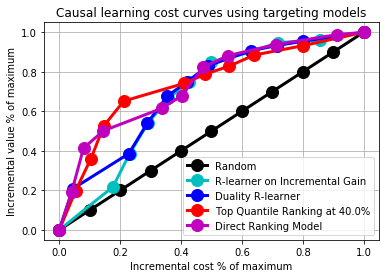

In [11]:
### code implements ranking model for treatment effect 
### for optimizing with respect to direct marketplace objectives 
### using tensorflow 

import numpy as np, tensorflow as tf, pandas as pd, pickle as pkl 
sys.path.append('../')  
from ModelDefinitions import * 
from DataProcFunctions import * 

### RxGy TQR setting: 
p_quantile = 0.4 ## percentage of quantile to aim for 
num_optimize_iterations = 2100 ## number of optimization iterations 
num_modeling_inits = 3 ## number of random initializations 
num_hidden = 0 ## number of hidden units in DNN 
use_schedule = True ## option to use a constraint annealing schedule 
temp = 0.5 ## initial temperature for constraints 
inc_temp = 0.1 ## increment of temperature per 100 iterations 
save_cf_data = False ### whether to save data for causal forest training 

## set a random seed to reproduce results 
seed = 1234; tf.compat.v2.random.set_seed(seed); np.random.seed(seed) 

sample_frac = 1.0 ## option to sample data by a fraction \in (0, 1) 
data_filename =  '../data/rt_ma_training_data_v5_2019_07_08_vc_tr_featuremod3' 
prefix = 'rt_v5_07_08_featuremod3_tr_iter100_run4' 

D_tre, D_unt, Dv_tre, Dv_unt, Dt_tre, Dt_unt, o_tre, o_unt, ov_tre, ov_unt, ot_tre, ot_unt, c_tre, c_unt, cv_tre, cv_unt, ct_tre, ct_unt, D, w, o, c, Dv, wv, ov, cv, Dt, wt, ot, ct = LoadDataFromPkl(data_filename, frac = sample_frac, use_python3=use_python3, save_cf_data=save_cf_data) 

print('### ----- start the training of deep learning models ------ ') 
gs_tqr = [] 
gs_drm = [] 
for i in range(num_modeling_inits): 
    gs_tqr.append(tf.Graph()) 
for i in range(num_modeling_inits): 
    gs_drm.append(tf.Graph()) 

print('------> Training TQR ranking model .... ') 
val_results = [] 
sess_list = [] 
for i in range(num_modeling_inits): 
    print('---> running cross validation, iteration: ' + str(i)) 
    obj, opt, dumh, dumhu, vtemp, p_quantile = TunableTQRankingModelDNN(gs_tqr[i], D_tre, D_unt, o_tre, o_unt, c_tre, c_unt, 'train-first', temp, p_quantile, num_hidden, use_schedule) 
    ### session definitions and variable initialization 
    sess = tf.Session(graph = gs_tqr[i]) 
    sess_list.append(sess) 
    
    ### initialize variables and run optimization 
    with gs_tqr[i].as_default() as g: 
        init = tf.global_variables_initializer() 
    sess.run(init) 
    cur_temp = temp 
    for step in range(num_optimize_iterations): 
        _, objres = sess.run([opt, obj]) 
        if step % 100 == 0: 
            cur_temp = cur_temp + inc_temp 
            print('opt. step : ' + str(step) + ' obj: ' + str(objres)) 
            if use_schedule: 
                sess.run(vtemp.assign(cur_temp))
                print('setting temperature to :' + str(sess.run(vtemp))) 
    
    print('---> optimization finished ... ') 
    tempvalue = sess.run(vtemp)
    p_quantilevalue = p_quantile
    print('temp:') 
    print(tempvalue)
    print('p_quantile:')
    print(p_quantilevalue) 
    
    ### evaluate CPIT metric on validation set 
    objv, dumo, dumh, dumhu, dvtemp, dp_quantile = TunableTQRankingModelDNN(gs_tqr[i], Dv_tre, Dv_unt, ov_tre, ov_unt, cv_tre, cv_unt, 'eval', temp, p_quantile, num_hidden, use_schedule) 
    
    val_result = sess.run(objv) 
    print('validation CPIT:') 
    print(val_result) 
    val_results.append(val_result) 

from operator import itemgetter 
best_index = min(enumerate(val_results), key=itemgetter(1))[0] 

print('best performing model: iteration ' + str(best_index)) 

### run scoring on whole test set 
with gs_tqr[best_index].as_default() as g: 
    if num_hidden > 0: 
        with tf.variable_scope("tqrhidden") as scope: 
            h1_test = tf.contrib.layers.fully_connected(Dt, num_hidden, activation_fn=tf.nn.tanh, reuse=tf.AUTO_REUSE, scope=scope, weights_initializer=tf.contrib.layers.xavier_initializer()) 
        with tf.variable_scope("tqranker") as scope: 
            h_test = tf.contrib.layers.fully_connected(h1_test, 1, activation_fn=None, reuse=tf.AUTO_REUSE, scope=scope) 
    else: 
        with tf.variable_scope("tqranker") as scope: 
            h_test = tf.contrib.layers.fully_connected(Dt, 1, activation_fn=None, reuse=tf.AUTO_REUSE, scope=scope) 
    tqrscore = sess_list[best_index].run(h_test) 

print('------> Training DRM ranking model .... ') 
sess_list = [] 
val_results = [] 
for i in range(num_modeling_inits): 
    print('---> running cross validation, iteration: ' + str(i)) 
    ### ---- train cpit ranking model for comparison --- 
    dobjc, doptc, ddumh, ddumu = DirectRankingModelDNN(gs_drm[i], D_tre, D_unt, o_tre, o_unt, c_tre, c_unt, 'train-first-drm', num_hidden) 
    
    dsess = tf.Session(graph = gs_drm[i]) 
    sess_list.append(dsess) 
    
    ### initialize variables and run optimization 
    with gs_drm[i].as_default() as g: 
        dinit = tf.global_variables_initializer() 
    dsess.run(dinit) 
    for step in range(num_optimize_iterations): 
        _, dobjres = dsess.run([doptc, dobjc]) 
        if step % 100 == 0: 
            print('opt. step : ' + str(step) + ' obj: ' + str(dobjres)) 
    
    print('---> optimization finished ... ') 
    
    ### evaluate CPIT metric on validation set 
    dobjv, ddumo, dumh, dumhu = DirectRankingModelDNN(gs_drm[i], Dv_tre, Dv_unt, ov_tre, ov_unt, cv_tre, cv_unt, 'eval', num_hidden)
    val_result = dsess.run(dobjv) 
    print('validation CPIT:') 
    print(val_result) 
    val_results.append(val_result) 

best_index = min(enumerate(val_results), key=itemgetter(1))[0] 

print('best performing model: iteration ' + str(best_index)) 

### run scoring on whole test set 
with gs_drm[best_index].as_default() as g: 
    if num_hidden > 0: 
        with tf.variable_scope("drmhidden") as scope: 
            h1_test = tf.contrib.layers.fully_connected(Dt, num_hidden, activation_fn=tf.nn.tanh, reuse=tf.AUTO_REUSE, scope=scope, weights_initializer=tf.contrib.layers.xavier_initializer()) 
        with tf.variable_scope("drmranker") as scope: 
            h_test = tf.contrib.layers.fully_connected(h1_test, 1, activation_fn=tf.nn.tanh, reuse=tf.AUTO_REUSE, scope=scope) 
    else: 
        with tf.variable_scope("drmranker") as scope: 
            h_test = tf.contrib.layers.fully_connected(Dt, 1, activation_fn=tf.nn.tanh, reuse=tf.AUTO_REUSE, scope=scope) 
    drmscore = sess_list[best_index].run(h_test) 

### ---- train hte model for comparison ---- 
### we could utimize the original HTE functions 
from LinearHTEModels import * 
from PromotionModels import PromotionModels 

pmodels = PromotionModels() 

## set-up RLearner 
rl_ridge_model_O, rl_ridge_model_C = pmodels.fit_rlearner(D, o, c, w) 

## one model for order lift and one model for cost drop 
pred_values_va_rlearner_O = rl_ridge_model_O.predict(Dt) 
pred_values_va_rlearner_C = rl_ridge_model_C.predict(Dt) 

#plt.imagesc(np.concatneate(rl_ridge_model_O.params, ...params), axis=1) 

#if ranking_model == 'effectiveness-ratio': ## if we use the effectiveness ratio model, compute effectiveness ratio 
pred_values_va_rlearner = np.divide(np.maximum(pred_values_va_rlearner_O, 0), pred_values_va_rlearner_C + 1e-7) 

lhmodels = LinearHTEModels() 
lambds = [0.1] 
rlearnerscores = [] 
rl_ridge_model_L_list = [] 
## set-up lagrangian rlearner 
for i in range(len(lambds)): 
    lambd = lambds[i] 
    rl_ridge_model_L = lhmodels.fit_rlearner_lagrangian(D, o, c, w, lambd) 
    rl_ridge_model_L_list.append(rl_ridge_model_L) 
    rlearnerscores.append(rl_ridge_model_L.predict(Dt)) 

### ---- experimentation and plotting cost-curves ----- 
from experimentation import * 
exp = Experimentation() 
ranscore = np.random.rand(ot.shape[0], ) 
colors = ['b', 'c', 'g', 'y'] 
plt.figure() 
rlearnerauccs = [] 
ranaucc = exp.AUC_cpit_cost_curve_deciles_cohort(ranscore, ot, wt, -1.0 * ct, 'k', plot_random=True) 
quasiaucc = exp.AUC_cpit_cost_curve_deciles_cohort(pred_values_va_rlearner_O, ot, wt, -1.0 * ct, 'c') 
for i in range(len(lambds)): 
    rlearnerauccs.append(exp.AUC_cpit_cost_curve_deciles_cohort(rlearnerscores[i], ot, wt, -1.0 * ct, colors[i] )) 
#cfaucc = exp.AUC_cpit_cost_curve_deciles_cohort(cfscore, ot, wt, -1.0 * ct, 'g') # causal forest aucc and plotting 
tqraucc = exp.AUC_cpit_cost_curve_deciles_cohort(tqrscore, ot, wt, -1.0 * ct, 'r' ) 
drmaucc = exp.AUC_cpit_cost_curve_deciles_cohort(drmscore, ot, wt, -1.0 * ct, 'm' ) 
plt.title('Causal learning cost curves using targeting models') 

print('temp:') 
print(tempvalue) 
print('p_quantile:') 
print(p_quantilevalue) 

### --- add legeneds to plot ---- 
leg_str = ['Random'] 
leg_str.append('R-learner on Incremental Gain') 
for i in range(len(lambds)): 
    leg_str.append('Duality R-learner') 
#leg_str.append('Causal Forest') # causal forest result 
leg_str.append('Top Quantile Ranking at ' + str(p_quantile*100) + '%') 
leg_str.append('Direct Ranking Model') 
plt.legend(leg_str) 

### --- print out aucc results for different models --- 
print('AUCC results: ') 
print('random: ' + str(ranaucc)) 
print('rlearner: ' + str(quasiaucc)) 
i = 0
for rlearneraucc in rlearnerauccs: 
    print('duality rlearner ' + str(i + 1) + ' with lambda = ' + str(lambds[i]) + ':' + str(rlearneraucc)) 
    i = i + 1
print('drm: ' + str(drmaucc)) 
print('tqr: ' + str(tqraucc)) 

plt.show() 

### --- saving data to results folder ---- 
save_filename = '../results/benchmarkwithcv_tqr_drm_hte_'+prefix+'_main_results.pkl' 
saveD = {'tqrscore':tqrscore, 'drmscore':drmscore, 'quasiscore':pred_values_va_rlearner, 'quasiscore_O':pred_values_va_rlearner_O, 'rlearnerscore':rlearnerscores, 'ot':ot, 'wt':wt, 'ct':ct, 'tempvalue':tempvalue, 'p_quantilevalue':p_quantilevalue, 
         'tqraucc':tqraucc, 'drmaucc':drmaucc, 'rlearnerauccs':rlearnerauccs, 'ranaucc':ranaucc, 'quasiaucc':quasiaucc} 
#'cfscore':cfscore, causal forest scores 
pkl.dump(saveD, open(save_filename, 'wb')) 


rpu_control: 12.287294195253796
nipu_control: 1.3840908585676386
rpu_ft: 13.498947432576042
nipu_ft: -1.3405749456067013
---------------------------->>>>>>
perc - target: 0.10
treated_target_rpu: 13.76
treated_target_nipu: -2.08
nontreated_target_rpu: 12.21
nontreated_target_nipu: 1.39
treated_nontarget_rpu: 13.47
treated_nontarget_nipu: -1.26
nontreated_nontarget_rpu: 12.30
nontreated_nontarget_nipu: 1.38
--- with 9.9997252973656% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 2.2376278990628795
--> in non-targeted users: 
cpit = 2.2511284772570903
rpu_control: 12.29
nipu_control: 1.38
rpu_ft: 13.50
nipu_ft: -1.34
rpu_cohort: 12.44
nipu_cohort: 1.04
lift targeted cohort vs control: 0.01
lift random vs control: 0.10
cpit cohort vs control: 2.24
lift targeted-treated vs control: 0.12
cpit cohort: 2.236509
---------------------------->>>>>>
perc - target: 0.20
treated_target_rpu: 13.60
treated_target_nipu: -2.04
nontreated_targ

---------------------------->>>>>>
perc - target: 0.20
treated_target_rpu: 10.87
treated_target_nipu: -2.60
nontreated_target_rpu: 8.52
nontreated_target_nipu: 0.54
treated_nontarget_rpu: 14.16
treated_nontarget_nipu: -1.02
nontreated_nontarget_rpu: 13.23
nontreated_nontarget_nipu: 1.60
--- with 19.9994505947312% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 1.3407998717838094
--> in non-targeted users: 
cpit = 2.7894326602669937
rpu_control: 12.29
nipu_control: 1.38
rpu_ft: 13.50
nipu_ft: -1.34
rpu_cohort: 12.75
nipu_cohort: 0.76
lift targeted cohort vs control: 0.04
lift random vs control: 0.10
cpit cohort vs control: 1.35
lift targeted-treated vs control: -0.12
cpit cohort: 1.347043
---------------------------->>>>>>
perc - target: 0.30
treated_target_rpu: 11.23
treated_target_nipu: -1.97
nontreated_target_rpu: 9.04
nontreated_target_nipu: 0.68
treated_nontarget_rpu: 14.48
treated_nontarget_nipu: -1.07
nontreated_nontarge

---------------------------->>>>>>
perc - target: 0.30
treated_target_rpu: 11.10
treated_target_nipu: -1.97
nontreated_target_rpu: 8.90
nontreated_target_nipu: 0.66
treated_nontarget_rpu: 14.55
treated_nontarget_nipu: -1.07
nontreated_nontarget_rpu: 13.73
nontreated_nontarget_nipu: 1.69
--- with 29.999175892096808% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 1.1937475272611764
--> in non-targeted users: 
cpit = 3.4008874451885465
rpu_control: 12.29
nipu_control: 1.38
rpu_ft: 13.50
nipu_ft: -1.34
rpu_cohort: 12.94
nipu_cohort: 0.59
lift targeted cohort vs control: 0.05
lift random vs control: 0.10
cpit cohort vs control: 1.20
lift targeted-treated vs control: -0.10
cpit cohort: 1.202767
---------------------------->>>>>>
perc - target: 0.40
treated_target_rpu: 11.51
treated_target_nipu: -1.64
nontreated_target_rpu: 9.44
nontreated_target_nipu: 0.78
treated_nontarget_rpu: 14.85
treated_nontarget_nipu: -1.14
nontreated_nontar

---------------------------->>>>>>
perc - target: 0.40
treated_target_rpu: 11.21
treated_target_nipu: -0.83
nontreated_target_rpu: 9.22
nontreated_target_nipu: 0.61
treated_nontarget_rpu: 15.05
treated_nontarget_nipu: -1.69
nontreated_nontarget_rpu: 14.32
nontreated_nontarget_nipu: 1.90
--- with 39.9989011894624% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 0.7247267597812467
--> in non-targeted users: 
cpit = 4.919077292932711
rpu_control: 12.29
nipu_control: 1.38
rpu_ft: 13.50
nipu_ft: -1.34
rpu_cohort: 13.08
nipu_cohort: 0.81
lift targeted cohort vs control: 0.06
lift random vs control: 0.10
cpit cohort vs control: 0.73
lift targeted-treated vs control: -0.09
cpit cohort: 0.730712
---------------------------->>>>>>
perc - target: 0.50
treated_target_rpu: 11.52
treated_target_nipu: -1.48
nontreated_target_rpu: 9.71
nontreated_target_nipu: 0.75
treated_nontarget_rpu: 15.53
treated_nontarget_nipu: -1.19
nontreated_nontarget

---------------------------->>>>>>
perc - target: 0.50
treated_target_rpu: 11.80
treated_target_nipu: -1.31
nontreated_target_rpu: 10.15
nontreated_target_nipu: 0.89
treated_nontarget_rpu: 15.20
treated_nontarget_nipu: -1.37
nontreated_nontarget_rpu: 14.42
nontreated_nontarget_nipu: 1.88
--- with 49.99862648682801% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 1.3334616780159476
--> in non-targeted users: 
cpit = 4.17096980423303
rpu_control: 12.29
nipu_control: 1.38
rpu_ft: 13.50
nipu_ft: -1.34
rpu_cohort: 13.11
nipu_cohort: 0.29
lift targeted cohort vs control: 0.07
lift random vs control: 0.10
cpit cohort vs control: 1.33
lift targeted-treated vs control: -0.04
cpit cohort: 1.334399
---------------------------->>>>>>
perc - target: 0.60
treated_target_rpu: 12.21
treated_target_nipu: -1.15
nontreated_target_rpu: 10.54
nontreated_target_nipu: 0.99
treated_nontarget_rpu: 15.46
treated_nontarget_nipu: -1.63
nontreated_nontarg

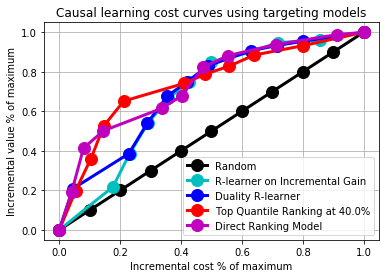

In [12]:
### ---- experimentation and plotting cost-curves ----- 
from experimentation import * 
exp = Experimentation() 
ranscore = np.random.rand(ot.shape[0], ) 
colors = ['b', 'c', 'g', 'y'] 
plt.figure() 
rlearnerauccs = [] 
ranaucc = exp.AUC_cpit_cost_curve_deciles_cohort(ranscore, ot, wt, -1.0 * ct, 'k', plot_random=True) 
quasiaucc = exp.AUC_cpit_cost_curve_deciles_cohort(pred_values_va_rlearner_O, ot, wt, -1.0 * ct, 'c') 
for i in range(len(lambds)): 
    rlearnerauccs.append(exp.AUC_cpit_cost_curve_deciles_cohort(rlearnerscores[i], ot, wt, -1.0 * ct, colors[i] )) 
#cfaucc = exp.AUC_cpit_cost_curve_deciles_cohort(cfscore, ot, wt, -1.0 * ct, 'g') # causal forest aucc and plotting 
tqraucc = exp.AUC_cpit_cost_curve_deciles_cohort(tqrscore, ot, wt, -1.0 * ct, 'r' ) 
drmaucc = exp.AUC_cpit_cost_curve_deciles_cohort(drmscore, ot, wt, -1.0 * ct, 'm' ) 
plt.title('Causal learning cost curves using targeting models') 

print('temp:') 
print(tempvalue) 
print('p_quantile:') 
print(p_quantilevalue) 

### --- add legeneds to plot ---- 
leg_str = ['Random'] 
leg_str.append('R-learner on Incremental Gain') 
for i in range(len(lambds)): 
    leg_str.append('Duality R-learner') 
#leg_str.append('Causal Forest') # causal forest result 
leg_str.append('Top Quantile Ranking at ' + str(p_quantile*100) + '%') 
leg_str.append('Direct Ranking Model') 
plt.legend(leg_str) 

### --- print out aucc results for different models --- 
print('AUCC results: ') 
print('random: ' + str(ranaucc)) 
print('rlearner: ' + str(quasiaucc)) 
i = 0
for rlearneraucc in rlearnerauccs: 
    print('duality rlearner ' + str(i + 1) + ' with lambda = ' + str(lambds[i]) + ':' + str(rlearneraucc)) 
    i = i + 1
print('drm: ' + str(drmaucc)) 
print('tqr: ' + str(tqraucc)) 

plt.show() 

### --- saving data to results folder ---- 
save_filename = '../results/benchmarkwithcv_tqr_drm_hte_'+prefix+'_main_results.pkl' 
saveD = {'tqrscore':tqrscore, 'drmscore':drmscore, 'quasiscore':pred_values_va_rlearner, 'quasiscore_O':pred_values_va_rlearner_O, 'rlearnerscore':rlearnerscores, 'ot':ot, 'wt':wt, 'ct':ct, 'tempvalue':tempvalue, 'p_quantilevalue':p_quantilevalue, 
         'tqraucc':tqraucc, 'drmaucc':drmaucc, 'rlearnerauccs':rlearnerauccs, 'ranaucc':ranaucc, 'quasiaucc':quasiaucc} 
#'cfscore':cfscore, causal forest scores 
pkl.dump(saveD, open(save_filename, 'wb')) 
